<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Final Project: Silicon Valley Neighborhood Research</font></h1>

### Introduction
This project is to investigate Silicon Valley Neighborhood based on FourSquare API and clustering data science method

### Set up Environment

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import csv
import time

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library
import matplotlib.pyplot as plt
%matplotlib inline

### Download the data from data.gov & Convert raw data into pd.DataFrame

In [2]:
url = 'https://data.sfgov.org/api/views/f9wk-m4qb/rows.csv?accessType=DOWNLOAD'
raw_data = pd.read_csv(url)
data = raw_data

### **Part 1 Reform DataFrame

In [3]:
# Need to switch 'the_geom' into [latitude, longitude]; create area center as in 'latitude' and 'longitude' columns
import re
def extractFloat(temp):
    output = re.findall(r"[-+]?\d*\.\d+|\d+", temp)
    output = [float(i) for i in output]
    return output
    
geo = data["the_geom"].str.split("MULTIPOLYGON", n = 1, expand = True)[1] 
latitude  = []
longitude = []
for j in range(len(geo)):
    lat  = []
    long = []
    lat  = extractFloat(geo[j])[1::2]
    long = extractFloat(geo[j])[0::2]
    latitude.append(np.array(lat).mean())
    longitude.append(np.array(long).mean())

data['latitude']  = latitude
data['longitude'] = longitude
data = data[data['PO_NAME'] != 'TRAVIS AFB']
city_ls           = data.PO_NAME.unique().tolist()

In [4]:
# Area List by City Name
area_ls = data.groupby('PO_NAME').sum()['Area__']

In [5]:
urlSJ  = 'https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&q=San+Jose+CA&timezone=America/Los_Angeles&use_labels_for_header=true'
dataSJ = pd.read_csv(urlSJ,sep=';')
dataSJ = dataSJ.rename(columns={"Zip": "ZIP", "Latitude": "latitude","Longitude":'longitude','City':'PO_NAME','State':'STATE'})
dataSJ['PO_NAME'] = dataSJ['PO_NAME'].str.upper()
dataSJ = dataSJ.drop(["Timezone", "Daylight savings time flag", "geopoint"], axis=1)
#dataSJ.head()
data   = data.append(dataSJ, ignore_index=True, sort=False)

santaclara = ['SANTA CLARA','NA',95051,'CA','NA','NA',37.3541, -121.9552]
cupertino  = ['CUPERTINO','NA',95014,'CA','NA','NA',37.3230, -122.0322]
campbell   = ['CAMPBELL','NA',95008,'CA','NA','NA',37.2872, -121.9500]
dataex     = pd.DataFrame([santaclara,cupertino,campbell], columns=data.columns)  
data       = data.append(dataex, ignore_index=True, sort=False)
data.drop_duplicates(subset ="ZIP", keep = False, inplace = True)
print("There are {} unique cities found in Greater San Francisco Bay Area.".format(len(data.PO_NAME.unique())))
data.head()

There are 99 unique cities found in Greater San Francisco Bay Area.


,PO_NAME,the_geom,ZIP,STATE,Area__,Length__,latitude,longitude
0,NAPA,MULTIPOLYGON (((-122.10329200180091 38.5132829...,94558,CA,1.23133e+10,995176,38.410697,-122.298535
1,FAIRFIELD,MULTIPOLYGON (((-121.947475002335 38.301511000...,94533,CA,9.91786e+08,200773,38.279137,-122.025948
2,DIXON,MULTIPOLYGON (((-121.65335500334429 38.3133870...,95620,CA,7.23695e+09,441860,38.434585,-121.781528
3,SONOMA,MULTIPOLYGON (((-122.406843003057 38.155681999...,95476,CA,3.00141e+09,311319,38.279666,-122.456603
4,NAPA,MULTIPOLYGON (((-122.29368500225117 38.1552379...,94559,CA,1.1943e+09,359105,38.266265,-122.311414


### **Part 2 Access to Foursqaure database

In [6]:
# Input Foursquare ID/Secret/Version
CLIENT_ID = 'TJ0SPQOHXOF5CJGO2BUHJM2ZXXEJK3K1WQZZWG2Y23XZN025' # your Foursquare ID
CLIENT_SECRET = 'NQEXK1ULW5FOTFHEOROXCF4U1VELGW4N2GAD4IYNDET0VIKI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: TJ0SPQOHXOF5CJGO2BUHJM2ZXXEJK3K1WQZZWG2Y23XZN025
CLIENT_SECRET:NQEXK1ULW5FOTFHEOROXCF4U1VELGW4N2GAD4IYNDET0VIKI


In [7]:
# Test Run by only using the first row input
# Get neighborhood Data
bay_latitude = data.loc[0, 'latitude'] # neighborhood latitude value
bay_longitude = data.loc[0, 'longitude'] # neighborhood longitude value

bay_name = data.loc[0, 'PO_NAME'] # neighborhood name

print('Latitude and longitude values of first row "{}" are ({}, {}).'.format(bay_name, 
                                                               bay_latitude, 
                                                               bay_longitude))

LIMIT  = 20 # limit of number of venues returned by Foursquare API
radius = 10000 # define radius
price  = 2

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&price={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    bay_latitude, 
    bay_longitude, 
    radius,
    price,
    LIMIT)
url # display URL
results = requests.get(url).json()
#results

Latitude and longitude values of first row "NAPA" are (38.41069666247486, -122.29853512315688).


In [8]:
# Function that extracts the category of the venue
LIMIT        = 20
radius_range = 10000

def getNearbyVenues(names, latitudes, longitudes, radius=radius_range):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['location', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Category']
    
    return(nearby_venues)

In [9]:
bay_venues = getNearbyVenues(names=data['PO_NAME'],
                             latitudes=data['latitude'],
                             longitudes=data['longitude']
                            )

print("Bay Area Venues shape: {}".format(bay_venues.shape))
bay_venues.head(20)

NAPA
FAIRFIELD
DIXON
SONOMA
NAPA
PETALUMA
RIO VISTA
AMERICAN CANYON
NOVATO
NOVATO
BIRDS LANDING
VALLEJO
BENICIA
VALLEJO
VALLEJO
NOVATO
VALLEJO
NICASIO
OAKLEY
CROCKETT
PORT COSTA
SUISUN CITY
SAN FRANCISCO
PITTSBURG
SAN RAFAEL
CONCORD
RODEO
MARTINEZ
HERCULES
SAN GERONIMO
LAGUNITAS
ALAMEDA
ANTIOCH
SAN ANSELMO
BRENTWOOD
SAN FRANCISCO
CONCORD
FAIRFAX
WOODACRE
FOREST KNOLLS
WALNUT CREEK
PINOLE
RICHMOND
CONCORD
SAN PABLO
SAN RAFAEL
ANTIOCH
EL SOBRANTE
OAKLAND
PLEASANT HILL
CONCORD
GREENBRAE
SAN FRANCISCO
LAFAYETTE
CLAYTON
RICHMOND
RICHMOND
LARKSPUR
SAN QUENTIN
EL CERRITO
CORTE MADERA
WALNUT CREEK
BERKELEY
SAN FRANCISCO
MILL VALLEY
ORINDA
BERKELEY
BERKELEY
BYRON
STINSON BEACH
ALBANY
BERKELEY
SAN FRANCISCO
WALNUT CREEK
BERKELEY
BERKELEY
BERKELEY
ALAMO
BERKELEY
SAUSALITO
MORAGA
BELVEDERE TIBURON
SAN FRANCISCO
BERKELEY
OAKLAND
OAKLAND
OAKLAND
LIVERMORE
EMERYVILLE
DIABLO
DANVILLE
DANVILLE
SAN FRANCISCO
OAKLAND
SAN FRANCISCO
OAKLAND
SAN RAMON
OAKLAND
OAKLAND
CASTRO VALLEY
SAN FRANCISCO
SAN FRANCISC

,location,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,NAPA,38.410697,-122.298535,Regusci Winery,38.397917,-122.313842,Winery
1,NAPA,38.410697,-122.298535,Stag's Leap Wine Cellars,38.398948,-122.323333,Winery
2,NAPA,38.410697,-122.298535,Clos Du Val Winery,38.386832,-122.312684,Winery
3,NAPA,38.410697,-122.298535,Stags' Leap Manor,38.414180,-122.321451,Vineyard
4,NAPA,38.410697,-122.298535,Pine Ridge Vineyards,38.405997,-122.331374,Vineyard
5,NAPA,38.410697,-122.298535,Chimney Rock Winery,38.390511,-122.313719,Winery
6,NAPA,38.410697,-122.298535,Robert Sinskey Vineyards,38.425266,-122.337051,Wine Bar
7,NAPA,38.410697,-122.298535,Cliff Lede Vineyards,38.424207,-122.344516,Winery
8,NAPA,38.410697,-122.298535,Silverado Vineyards,38.412351,-122.337094,Vineyard
9,NAPA,38.410697,-122.298535,Hotel Yountville,38.398128,-122.357733,Hotel


In [11]:
bay_venues.rename(columns={'City Latitude':'latitude','City Longitude':'longitude'}, inplace=True)
baydata = pd.merge(bay_venues, data[['ZIP','longitude']], on='longitude')
print("The shape of Bay Area Raw Data extracted through FourSqaure API is {}".format(baydata.shape))
print("There are {} unique neighborhoods according to zip-code and {} unique cities.".format(len(baydata.ZIP.unique()),len(baydata.location.unique())))
baydata.head()

The shape of Bay Area Raw Data extracted through FourSqaure API is (23538, 8)
There are 249 unique neighborhoods according to zip-code and 99 unique cities.


,location,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Category,ZIP
0,NAPA,38.410697,-122.298535,Regusci Winery,38.397917,-122.313842,Winery,94558
1,NAPA,38.410697,-122.298535,Stag's Leap Wine Cellars,38.398948,-122.323333,Winery,94558
2,NAPA,38.410697,-122.298535,Clos Du Val Winery,38.386832,-122.312684,Winery,94558
3,NAPA,38.410697,-122.298535,Stags' Leap Manor,38.414180,-122.321451,Vineyard,94558
4,NAPA,38.410697,-122.298535,Pine Ridge Vineyards,38.405997,-122.331374,Vineyard,94558


In [12]:
# Backup raw data to csv
baydata.to_csv(r'C:\Users\sywan\Anaconda3\_NoteBook\BayAreaData.csv')

In [13]:
# Read csv if necessary
baydata = pd.read_csv(r'C:\Users\sywan\Anaconda3\_NoteBook\BayAreaData.csv')

### **Part 3 Create map of Bay Area

In [14]:
# create map of SF Bay Area using latitude and longitude values
import folium
lat_bay  = 37.3872782660371
long_bay = -122.023027702134
map_bay  = folium.Map(location=[lat_bay, long_bay], zoom_start=10)

# add markers to map
for lat, lng, label in zip(data['latitude'], data['longitude'], data['PO_NAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bay)  
    
map_bay

### **Part 4 Analyze Data

In [15]:
# one hot encoding
bay_onehot = pd.get_dummies(baydata[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe|
bay_onehot['location'] = baydata['location'] 

# move neighborhood column to the first column
fixed_columns = [bay_onehot.columns[-1]] + list(bay_onehot.columns[:-1])
bay_onehot = bay_onehot[fixed_columns]

bay_onehot.head()

,location,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Basketball Court,College Bookstore,College Theater,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Fondue Restaurant,Food,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mongolian Restaurant,Monument / Landmark,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Observatory,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Rest Area,Restaurant,Road,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Swim School,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trade School,Trail,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Vineyard,Warehouse Store,Water Park,Waterfall,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store

In [16]:
#  Grouped Bay Data
baygp = bay_onehot.groupby('location').mean().reset_index()
baygp.head()

,location,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Basketball Court,College Bookstore,College Theater,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Fondue Restaurant,Food,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mongolian Restaurant,Monument / Landmark,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Observatory,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Rest Area,Restaurant,Road,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Swim School,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trade School,Trail,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Vineyard,Warehouse Store,Water Park,Waterfall,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store

In [17]:
# Create a mask to filter restaurant
col_ls  = baygp.columns.tolist()
food_ls = ['location','Restaurant','Steak','Buffet','Food','Pub']
mask    = [False] * len(col_ls)
for item in food_ls:
    temp = [i.find(item)>=0 for i in col_ls]
    mask = [x or y for x, y in zip(mask, temp)]

from itertools import compress
bayfood = baygp[list(compress(col_ls,mask))]
bayfood.head()


,location,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fondue Restaurant,Food,Food Court,Food Truck,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Health Food Store,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,New American Restaurant,Pakistani Restaurant,Peruvian Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Russian Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Street Food Gathering,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,ALAMEDA,0.0,0.0,0.0,0.0,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.025,0.0,0.00,0.0,0.00,0.05,0.025,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.05
1,ALAMO,0.0,0.1,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.050,0.0,0.00,0.0,0.05,0.00,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.00,0.00
2,ALBANY,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.05,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.05,0.0,0.00,0.00,0.000,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.05,0.05,0.00
3,ALVISO,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.00,0.0,0.05,0.05,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.05,0.00
4,AMERICAN CANYON,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.000,0.0,0.00,0.0,0.00,0.05,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.00,0.00,0.05


In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
bay_venues_sorted = pd.DataFrame(columns=columns)
bay_venues_sorted['location'] = bayfood['location']

for ind in np.arange(baygp.shape[0]):
    bay_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bayfood.iloc[ind, :], num_top_venues)

bay_venues_sorted.head()

,location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALAMEDA,Vietnamese Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Burmese Restaurant,German Restaurant,Italian Restaurant,Sushi Restaurant,Falafel Restaurant,Hawaiian Restaurant,Greek Restaurant
1,ALAMO,American Restaurant,Italian Restaurant,Thai Restaurant,Mediterranean Restaurant,Filipino Restaurant,Hotpot Restaurant,Health Food Store,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant
2,ALBANY,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,New American Restaurant,Food Truck,Vietnamese Restaurant,Filipino Restaurant,Health Food Store,Hawaiian Restaurant,Greek Restaurant
3,ALVISO,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Mexican Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Fondue Restaurant,Hotpot Restaurant,Health Food Store,Hawaiian Restaurant,Greek Restaurant
4,AMERICAN CANYON,Thai Restaurant,Vietnamese Restaurant,Mexican Restaurant,Indian Restaurant,Fast Food Restaurant,Hawaiian Restaurant,Greek Restaurant,Health Food Store,Filipino Restaurant,German Restaurant


In [20]:
# set number of clusters
kclusters = 10

bayfood_clustering = bayfood.drop('location', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bayfood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 7, 5, 2, 2, 7, 1, 7, 7])

In [21]:
# add clustering labels
bay_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bay_merged = baydata

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bay_merged = bay_merged.join(bay_venues_sorted.set_index('location'), on='location')

bay_merged.head() # check the last columns!

,Unnamed: 0,location,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Category,ZIP,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,NAPA,38.410697,-122.298535,Regusci Winery,38.397917,-122.313842,Winery,94558,7,French Restaurant,Italian Restaurant,Steakhouse,New American Restaurant,Restaurant,Tapas Restaurant,American Restaurant,Asian Restaurant,Filipino Restaurant,Health Food Store
1,1,NAPA,38.410697,-122.298535,Stag's Leap Wine Cellars,38.398948,-122.323333,Winery,94558,7,French Restaurant,Italian Restaurant,Steakhouse,New American Restaurant,Restaurant,Tapas Restaurant,American Restaurant,Asian Restaurant,Filipino Restaurant,Health Food Store
2,2,NAPA,38.410697,-122.298535,Clos Du Val Winery,38.386832,-122.312684,Winery,94558,7,French Restaurant,Italian Restaurant,Steakhouse,New American Restaurant,Restaurant,Tapas Restaurant,American Restaurant,Asian Restaurant,Filipino Restaurant,Health Food Store
3,3,NAPA,38.410697,-122.298535,Stags' Leap Manor,38.414180,-122.321451,Vineyard,94558,7,French Restaurant,Italian Restaurant,Steakhouse,New American Restaurant,Restaurant,Tapas Restaurant,American Restaurant,Asian Restaurant,Filipino Restaurant,Health Food Store
4,4,NAPA,38.410697,-122.298535,Pine Ridge Vineyards,38.405997,-122.331374,Vineyard,94558,7,French Restaurant,Italian Restaurant,Steakhouse,New American Restaurant,Restaurant,Tapas Restaurant,American Restaurant,Asian Restaurant,Filipino Restaurant,Health Food Store


### Examine the clusters

In [22]:
ClusterN = len(bay_merged['Cluster Labels'].unique())
ClusterLoc = []
FirstVenue = []
SecondVenue = []
ThirdVenue = []
Pop = []
for i in range(ClusterN):
    ClusterLoc.append(bay_merged[bay_merged['Cluster Labels'] == i]['location'].unique().tolist())
    FirstVenue.append(bay_merged[bay_merged['Cluster Labels'] == i]['1st Most Common Venue'].unique().tolist())
    SecondVenue.append(bay_merged[bay_merged['Cluster Labels'] == i]['2nd Most Common Venue'].unique().tolist())
    ThirdVenue.append(bay_merged[bay_merged['Cluster Labels'] == i]['3rd Most Common Venue'].unique().tolist())
    Pop.append(len(bay_merged[bay_merged['Cluster Labels'] == i]['Venue'].unique()))

df_cluster= pd.DataFrame({'Cluster#':list(range(ClusterN)),'Location':ClusterLoc, '1st Most Common Venue':FirstVenue,
                         '2nd Most Common Venue':SecondVenue, '3rd Most Common Venue':ThirdVenue,'Cluster Popularity':Pop})
df_cluster.sort_values(by='Cluster Popularity', ascending=False)

,Cluster#,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Cluster Popularity
7,7,"[NAPA, BIRDS LANDING, BENICIA, SAN FRANCISCO, ...","[French Restaurant, Vietnamese Restaurant, Caj...","[Italian Restaurant, Israeli Restaurant, Sushi...","[Steakhouse, Hunan Restaurant, Restaurant, Sus...",971
2,2,"[FAIRFIELD, PETALUMA, RIO VISTA, AMERICAN CANY...","[Fast Food Restaurant, Mexican Restaurant, Tha...","[Steakhouse, Italian Restaurant, American Rest...","[Food Truck, New American Restaurant, Mexican ...",594
8,8,"[CROCKETT, PORT COSTA, RODEO, HERCULES, GREENB...","[Mexican Restaurant, Restaurant, American Rest...","[American Restaurant, Thai Restaurant, Seafood...","[Seafood Restaurant, Thai Restaurant, Asian Re...",191
0,0,"[PITTSBURG, SAN RAFAEL, CONCORD, MARTINEZ, PLE...",[Mexican Restaurant],"[Vietnamese Restaurant, Italian Restaurant, Am...","[Indian Restaurant, New American Restaurant, A...",190
1,1,"[FAIRFAX, WOODACRE, CLAYTON, MILL VALLEY, MORA...","[Italian Restaurant, Chinese Restaurant]","[Cajun / Creole Restaurant, American Restauran...","[Japanese Restaurant, Filipino Restaurant, Fas...",183
5,5,"[DIXON, BYRON, EMERYVILLE, PLEASANTON, SAN CAR...","[Steakhouse, Latin American Restaurant, Fast F...","[Mexican Restaurant, American Restaurant, Medi...","[Indian Restaurant, Sushi Restaurant, Vietname...",166
4,4,"[SONOMA, NICASIO, SUISUN CITY, LAGUNITAS, LAFA...","[American Restaurant, Italian Restaurant]","[Restaurant, Indian Restaurant, New American R...","[French Restaurant, Filipino Restaurant, Food,...",153
6,6,"[SAN ANSELMO, SAN BRUNO, SAN MATEO, NEWARK, CU...","[Mexican Restaurant, Sushi Restaurant, Japanes...","[Mediterranean Restaurant, Hunan Restaurant, M...","[Cajun / Creole Restaurant, Filipino Restauran...",131
9,9,"[SAN GERONIMO, FOREST KNOLLS]",[Indian Restaurant],[American Restaurant],[Japanese Restaurant],21
3,3,[MOUNT HAMILTON],[Restaurant],[Vietnamese Restaurant],[Hunan Restaurant],4


In [39]:
for i in range(ClusterN):
    print('*** Cluster #{} with Popularity of {} loves {}.'.format(i, Pop[i], ', '.join(FirstVenue[i])))
    print('    This cluster includes Cities:')
    print(', '.join(ClusterLoc[i]))
    print('\n')


*** Cluster #0 with Popularity of 190 loves Mexican Restaurant.
    This cluster includes Cities:
PITTSBURG, SAN RAFAEL, CONCORD, MARTINEZ, PLEASANT HILL, SAN QUENTIN, SOUTH SAN FRANCISCO, HALF MOON BAY


*** Cluster #1 with Popularity of 183 loves Italian Restaurant, Chinese Restaurant.
    This cluster includes Cities:
FAIRFAX, WOODACRE, CLAYTON, MILL VALLEY, MORAGA, SAN RAMON, DALY CITY, BURLINGAME, BELMONT, CAMPBELL


*** Cluster #2 with Popularity of 594 loves Fast Food Restaurant, Mexican Restaurant, Thai Restaurant, Vietnamese Restaurant, American Restaurant.
    This cluster includes Cities:
FAIRFIELD, PETALUMA, RIO VISTA, AMERICAN CANYON, NOVATO, VALLEJO, OAKLEY, ALAMEDA, ANTIOCH, BRENTWOOD, PINOLE, RICHMOND, SAN PABLO, EL SOBRANTE, SAN LEANDRO, HAYWARD, UNION CITY, SAN JOSE


*** Cluster #3 with Popularity of 4 loves Restaurant.
    This cluster includes Cities:
MOUNT HAMILTON


*** Cluster #4 with Popularity of 153 loves American Restaurant, Italian Restaurant.
    This clus

In [25]:
cityll  = bay_merged.groupby('location').mean().reset_index()
cityll.head()

,location,Unnamed: 0,latitude,longitude,Venue Latitude,Venue Longitude,ZIP,Cluster Labels
0,ALAMEDA,1374.0,37.756771,-122.254520,37.771110,-122.255901,94501.5,2
1,ALAMO,1524.5,37.856373,-122.001410,37.831987,-122.001556,94507.0,4
2,ALBANY,1384.5,37.888848,-122.294584,37.885405,-122.294238,94706.0,7
3,ALVISO,3263.5,37.434766,-121.982307,37.401431,-121.973571,95002.0,5
4,AMERICAN CANYON,149.5,38.182079,-122.247359,38.157634,-122.241541,94503.0,2


In [26]:
cityll  = bay_merged.groupby('location').mean().reset_index()
# create map
map_clusters = folium.Map(location=[lat_bay, long_bay], zoom_start=9)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cityll['latitude'], cityll['longitude'], cityll['location'], cityll['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

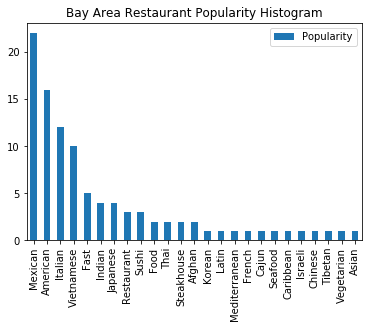

<Figure size 360x288 with 0 Axes>

In [28]:
store_1st = bay_venues_sorted.groupby('1st Most Common Venue').count()['location']
store_2nd = bay_venues_sorted.groupby('2nd Most Common Venue').count()['location']
bay_1st = pd.DataFrame({'1st Most Popular Restaurant':store_1st.index.tolist(),'Popularity':store_1st.tolist()})
bay_1st=bay_1st.sort_values(by='Popularity', ascending=False).reset_index().drop(['index'],axis=1)
shortname = [item.split(" ")[0] for item in bay_1st['1st Most Popular Restaurant'].tolist()]

bay_1st.plot(kind='bar')
plt.title('Bay Area Restaurant Popularity Histogram')
plt.xticks(bay_1st.index, shortname)
plt.figure(figsize=(5,4))

plt.show()


#### Conclusions:
Please see the report for details.